<a href="https://colab.research.google.com/github/athishr88/NN_DL/blob/main/LA3/LA3_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports and dataset loading

import nlp

dataset = nlp.load_dataset('emotion')
train = dataset['train']
val = dataset['validation']
test = dataset['test']

Using custom data configuration default


In [2]:
## Prepare input and output pairs for train dataset
import numpy as np

train_samples = [x['text'] for x in train]
train_labels = [x['label'] for x in train]

## Convert each label in the output to a unique integer
classes = list(set(train_labels))
class_to_index = dict((c,i) for i, c in enumerate(classes))
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

## Convert the train labels to corresponding int values
train_labels = names_to_ids(train_labels)

In [3]:
## Prep the val dataset
val_samples = [x['text'] for x in val]
val_labels = [x['label'] for x in val]
val_labels = names_to_ids(val_labels)

# Prep the test dataset
test_samples = [x['text'] for x in test]
test_labels = [x['label'] for x in test]
test_labels = names_to_ids(test_labels)

In [4]:
## Create our Text Vectorizer to index our vocabulary based on the train samples 
from keras.layers import TextVectorization
import tensorflow as tf

vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128) ## Read batches of 128 samples
vectorizer.adapt(text_ds)

In [5]:
## Print out top five words in the vocab
print(len(vectorizer.get_vocabulary())) ## We set max_tokens=10000
vectorizer.get_vocabulary()[:5]

10000


['', '[UNK]', 'i', 'feel', 'and']

In [6]:
## Create a map to get the unique list of the vocabulary
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [7]:
## Vectorize our data (Convert the string data to integer data)
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(test_labels)

In [8]:
# ## Download and unzip the Stanford GloVe model (pretrained word embeddings)AA
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [9]:
!pip install --upgrade gensim

In [10]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  after removing the cwd from sys.path.


(400000, 100)

In [11]:
## Read the embeddings in the pretrained glove model 
import os
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index_glove = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_glove[word] = coefs

print("Found %s word vectors." % len(embeddings_index_glove))

Found 400000 word vectors.


In [12]:
## Read the embeddings in the pretrained w2v model 
import os
path_to_w2v_file = 'glove.6B.100d.txt.word2vec'

embeddings_index_w2v = {}
with open(path_to_w2v_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index_w2v[word] = coefs

print("Found %s word vectors." % len(embeddings_index_w2v))

Found 400001 word vectors.


In [13]:
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix_glove = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_glove.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_glove[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9627 words (373 misses)


In [14]:
## Create "embedding_matrix" to index our vocabulary using the w2v model 
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix_w2v = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index_w2v.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix_w2v[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 9627 words (373 misses)


In [15]:
## Define our embedding layer for the training model 
## We load our embedding_matrix as the initializer and set trainable to False to avoid retraining this layer

from keras.layers import Embedding
from keras.initializers import Constant

embedding_layer_glove = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix_glove), 
                            trainable=False,
)

embedding_layer_w2v = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix_w2v), 
                            trainable=False,
)


Embedding used: glove
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 40)         19360     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 6)                 246       
                                                                 
Total params: 1,029,366
Trainable par

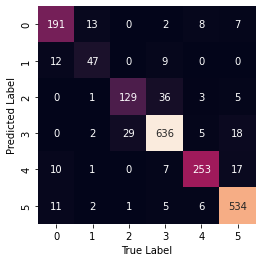

Embedding used: w2v
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 40)         19360     
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 6)                 246       
                                                                 
Total params: 1,029,366
Trainable param

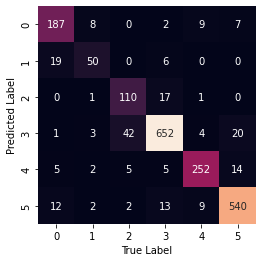

In [17]:
# Training different models
from keras.layers import SimpleRNN, GRU, LSTM
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from keras import layers, Input, Model
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

methods_list = ['glove', 'w2v']

for method in methods_list:
  int_sequences_input = Input(shape=(None,), dtype="int64")
  
  if method == 'glove':
    embedded_sequences = embedding_layer_glove(int_sequences_input)
  else:
    embedded_sequences = embedding_layer_w2v(int_sequences_input)

  x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
  x = layers.Bidirectional(layers.LSTM(20))(x)
  preds = layers.Dense(len(classes), activation="softmax")(x)
  model = Model(int_sequences_input, preds)
  print(f"Embedding used: {method}")
  model.summary()
  ## Train the model 
  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["acc"])
  model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val), verbose=1)
  
  # Test
  y_test_pred = model.predict(x_test)
  y_test_pred_labels = np.argmax(y_test_pred, axis=1)

  # Overall Precision
  print(metrics.classification_report(y_test, y_test_pred_labels))
  mat = confusion_matrix(y_test, y_test_pred_labels)
  plt.figure()
  sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False)
  plt.xlabel("True Label")
  plt.ylabel("Predicted Label")
  plt.show()